In [1]:
from IPython.display import display, clear_output
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25, train, SFD
from plots import plot_preprocessing, plot_sample_durations, plot_eeg_gradcpt_time_diff

eeg_data_1 = pd.read_csv('data/subject2/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv('data/subject2/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv('data/subject2/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv('data/subject2/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv('data/subject2/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv('data/subject2/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

In [2]:
# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

Gradcpt data had to be truncated
Gradcpt data had to be truncated


### z-normalization

In [3]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [4]:
for channel in channels:
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_normal'])

### Bandpass

In [5]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

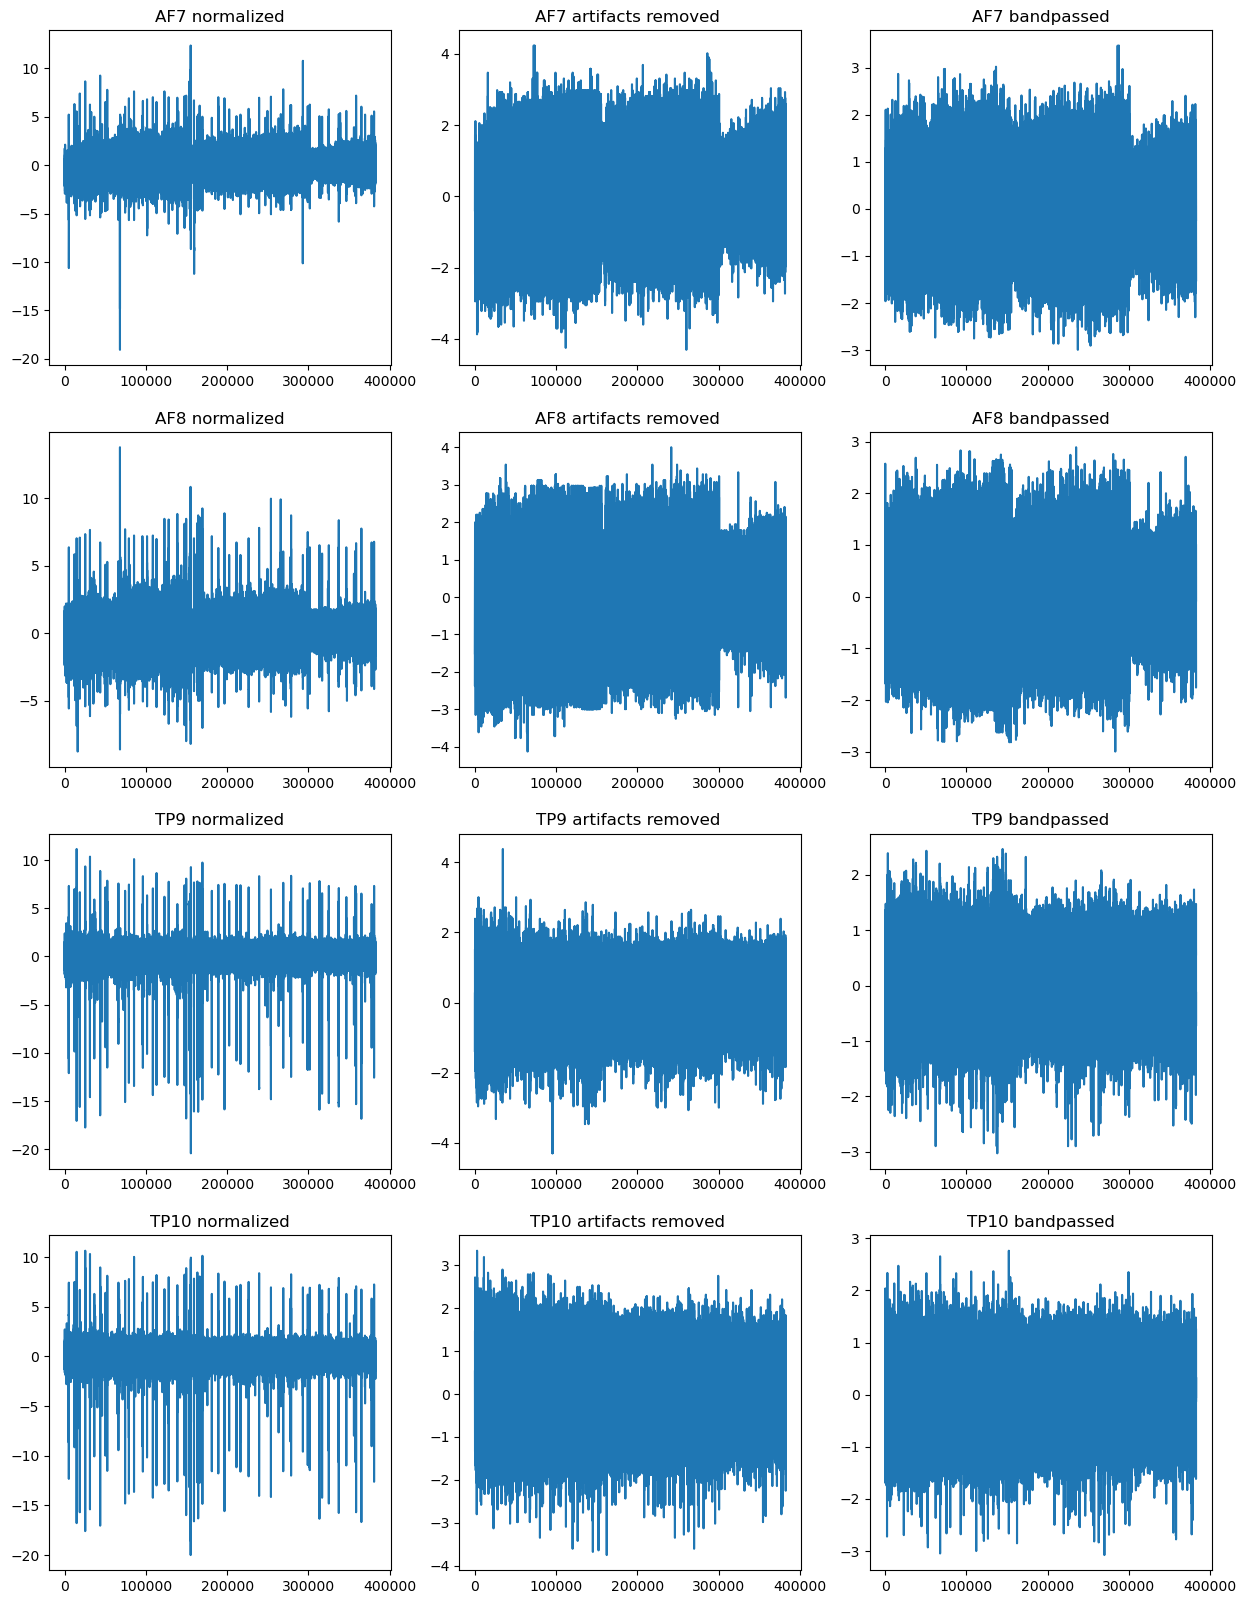

In [6]:
plot_preprocessing(channels=channels, eeg_df=eeg_data)

### Separate trials

In [7]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

### Time differences in trials

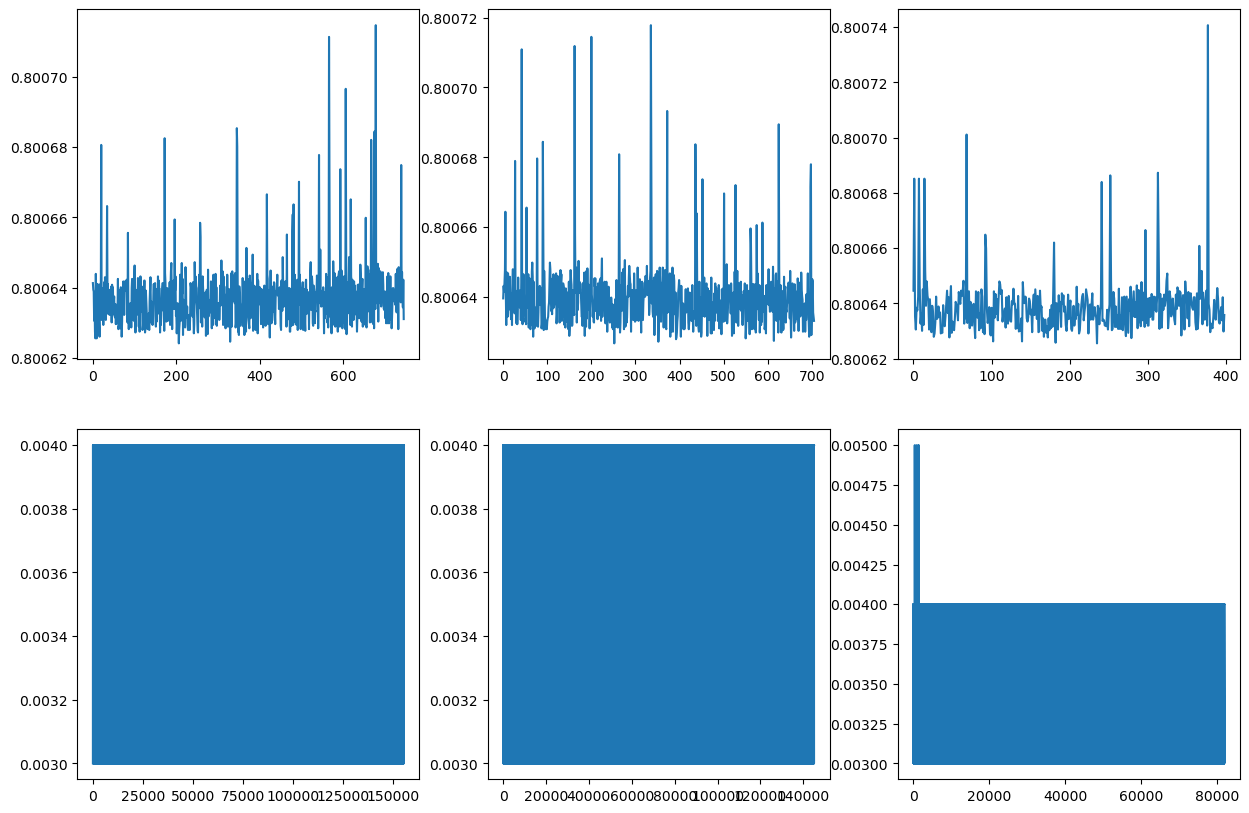

In [8]:
eeg_trials = [eeg_data_t1, eeg_data_t2, eeg_data_t3]
gradcpt_trials = [gradcpt_data_t1, gradcpt_data_t2, gradcpt_data_t3]
plot_sample_durations(eeg_trials, gradcpt_trials)

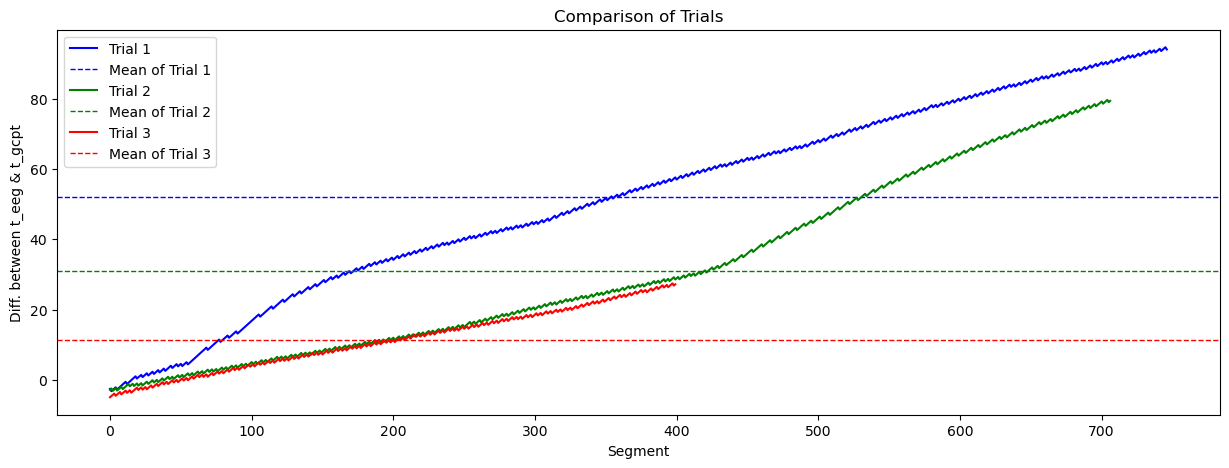

In [9]:
plot_eeg_gradcpt_time_diff(eeg_trials, gradcpt_trials)

### Extract features

In [10]:
# Initialize empty DataFrames for each trial
features_t1 = pd.DataFrame()
features_t2 = pd.DataFrame()
features_t3 = pd.DataFrame()

for trial in [1, 2, 3]:
    # Select the current trial data
    if trial == 1:
        cur_eeg_df = eeg_data_t1
        cur_gcpt_df = gradcpt_data_t1
    elif trial == 2:
        cur_eeg_df = eeg_data_t2
        cur_gcpt_df = gradcpt_data_t2
    else:
        cur_eeg_df = eeg_data_t3
        cur_gcpt_df = gradcpt_data_t3
    
    # Process each channel
    for i, channel in enumerate(channels):
        # Segment the current EEG data
        segments = segment_column(cur_eeg_df[f'{channel}_bandpassed'], cur_gcpt_df)
        # Decompose each segment
        segment_bands = [decompose_segment(segment) for segment in segments]
        # Extract features from the decomposed segments
        features = extract_features(channel, segment_bands)
        
        # Append the features to the respective DataFrame
        if trial == 1:
            features_t1 = pd.concat([features_t1, features], axis=1)
        elif trial == 2:
            features_t2 = pd.concat([features_t2, features], axis=1)
        else:
            features_t3 = pd.concat([features_t3, features], axis=1)
        
        clear_output(wait=True)
        print(f'{(trial-1)*len(channels)+i+1}/{3*len(channels)} Done')

features_t1['in_the_zone'] = gradcpt_data_t1['in_the_zone']
features_t2['in_the_zone'] = gradcpt_data_t2['in_the_zone']
features_t3['in_the_zone'] = gradcpt_data_t3['in_the_zone']

12/12 Done


In [11]:
combined_features_df = pd.concat([features_t1, features_t2, features_t3], ignore_index=True)

## Sequential feature detachment
### Combined channels

TRAINING RESULTS Full Features:
Optimal Alpha Full Features: 4832.93
Train Accuraccy Full Features: 82.86%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 30.00
Train Accuraccy Detach Model: 82.73%
-------------------------
Test Accuraccy Full Model: 59.14%
Test Accuraccy Detach Model: 59.50%


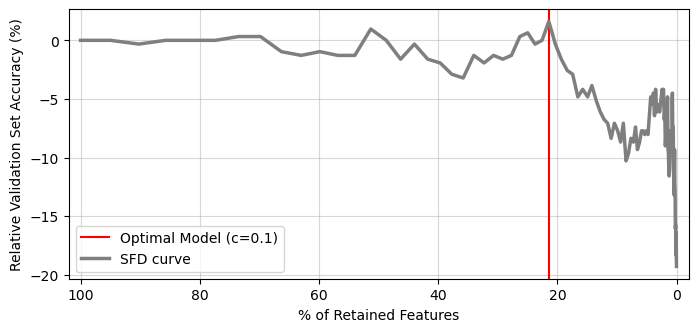

Optimal Model Size: 21.45% of full model
Number of features kept: 497
Number of features kept: 497


In [56]:
X_combined = combined_features_df.iloc[:, :-1]
y = combined_features_df.iloc[:, -1]

selected_features_all_channels = SFD(X_combined, y, 0.1);
print(f'Number of features kept: {len(selected_features_all_channels.columns)-1}')

### AF7

TRAINING RESULTS Full Features:
Optimal Alpha Full Features: 4832.93
Train Accuraccy Full Features: 66.79%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 8.00
Train Accuraccy Detach Model: 75.17%
-------------------------
Test Accuraccy Full Model: 62.37%
Test Accuraccy Detach Model: 59.50%


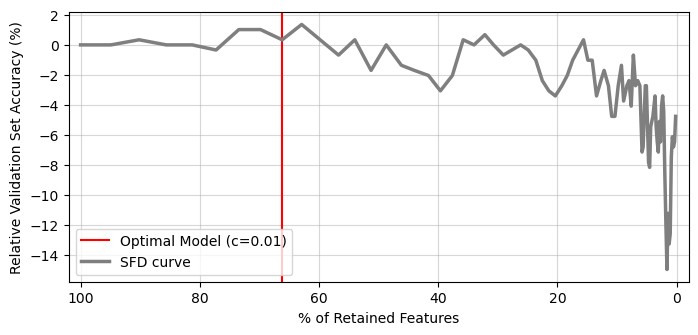

Optimal Model Size: 66.18% of full model
Number of features kept: 384


In [24]:
X_af7 = X_combined.filter(regex='^AF7.*')

selected_features_af7 = SFD(X_af7, y, 0.01)

### AF8

TRAINING RESULTS Full Features:
Optimal Alpha Full Features: 54555.95
Train Accuraccy Full Features: 58.41%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 10.00
Train Accuraccy Detach Model: 69.46%
-------------------------
Test Accuraccy Full Model: 54.12%
Test Accuraccy Detach Model: 59.14%


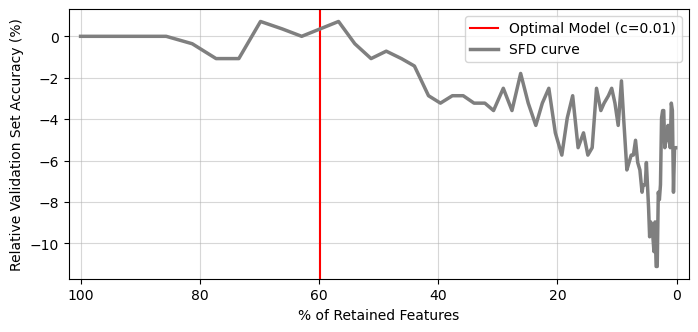

Optimal Model Size: 59.82% of full model
Number of features kept: 346


In [28]:
X_af8 = X_combined.filter(regex='^AF8.*')

selected_features_af8 = SFD(X_af8, y, 0.01)

### TP9

TRAINING RESULTS Full Features:
Optimal Alpha Full Features: 4832.93
Train Accuraccy Full Features: 66.48%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 7.00
Train Accuraccy Detach Model: 71.49%
-------------------------
Test Accuraccy Full Model: 57.71%
Test Accuraccy Detach Model: 53.76%


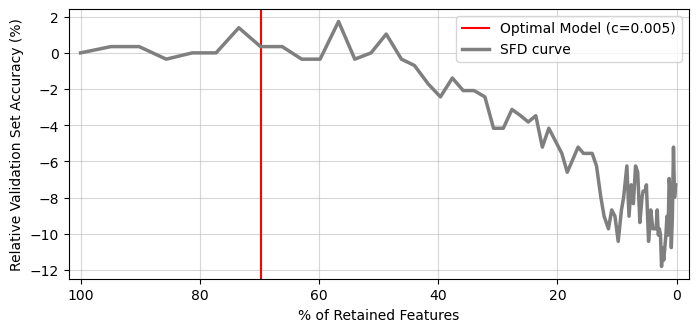

Optimal Model Size: 69.82% of full model
Number of features kept: 404
Number of features kept: 404


In [33]:
X_tp9 = X_combined.filter(regex='^TP9.*')

selected_features_tp9 = SFD(X_tp9, y, 0.005)
print(f'Number of features kept: {len(selected_features_tp9.columns)-1}')

### TP10

TRAINING RESULTS Full Features:
Optimal Alpha Full Features: 54555.95
Train Accuraccy Full Features: 59.24%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 5.00
Train Accuraccy Detach Model: 71.43%
-------------------------
Test Accuraccy Full Model: 52.33%
Test Accuraccy Detach Model: 50.90%


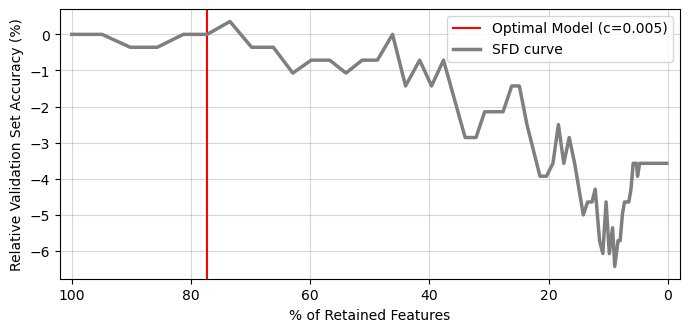

Optimal Model Size: 77.27% of full model
Number of features kept: 447
Number of features kept: 447


In [50]:
X_tp10 = X_combined.filter(regex='^TP10.*')

selected_features_tp10 = SFD(X_tp10, y, 0.005)
print(f'Number of features kept: {len(selected_features_tp10.columns)-1}')

### Train the model

In [14]:
df_AF7 = combined_features_df.filter(regex='^AF7.*')
df_AF7 = df_AF7.assign(Label=y)

df_AF8 = combined_features_df.filter(regex='^AF8.*')
df_AF8 = df_AF8.assign(Label=y)

df_TP9 = combined_features_df.filter(regex='^TP9.*')
df_TP9 = df_TP9.assign(Label=y)

df_TP10 = combined_features_df.filter(regex='^TP10.*')
df_TP10 = df_TP10.assign(Label=y);

In [15]:
print(train(runs=1, num_features=5, df=df_AF7))

54.5


In [57]:
res = {'combined': [], 'af7': [], 'af8': [], 'tp9': [], 'tp10': []}
for n_feats in range(1, len(selected_features_af8.columns)-1, 5):
    res['combined'].append(train(runs=5, num_features=n_feats, df=selected_features_all_channels))
    res['af7'].append(train(runs=5, num_features=n_feats, df=selected_features_af7))
    res['af8'].append(train(runs=5, num_features=n_feats, df=selected_features_af8))
    res['tp9'].append(train(runs=5, num_features=n_feats, df=selected_features_tp9))
    res['tp10'].append(train(runs=5, num_features=n_feats, df=selected_features_tp10))
    print(f'{n_feats} done')
    print(res)

1 done
{'combined': [51.26], 'af7': [54.26], 'af8': [50.52], 'tp9': [50.92], 'tp10': [51.68]}
6 done
{'combined': [51.26, 54.1], 'af7': [54.26, 53.0], 'af8': [50.52, 50.6], 'tp9': [50.92, 52.88], 'tp10': [51.68, 52.68]}
11 done
{'combined': [51.26, 54.1, 55.52], 'af7': [54.26, 53.0, 53.12], 'af8': [50.52, 50.6, 49.82], 'tp9': [50.92, 52.88, 53.56], 'tp10': [51.68, 52.68, 52.0]}
16 done
{'combined': [51.26, 54.1, 55.52, 55.48], 'af7': [54.26, 53.0, 53.12, 53.16], 'af8': [50.52, 50.6, 49.82, 49.9], 'tp9': [50.92, 52.88, 53.56, 53.72], 'tp10': [51.68, 52.68, 52.0, 51.96]}
21 done
{'combined': [51.26, 54.1, 55.52, 55.48, 55.78], 'af7': [54.26, 53.0, 53.12, 53.16, 53.7], 'af8': [50.52, 50.6, 49.82, 49.9, 49.18], 'tp9': [50.92, 52.88, 53.56, 53.72, 53.82], 'tp10': [51.68, 52.68, 52.0, 51.96, 51.52]}
26 done
{'combined': [51.26, 54.1, 55.52, 55.48, 55.78, 56.02], 'af7': [54.26, 53.0, 53.12, 53.16, 53.7, 54.14], 'af8': [50.52, 50.6, 49.82, 49.9, 49.18, 48.5], 'tp9': [50.92, 52.88, 53.56, 53.72

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Setup the plot
plt.figure(figsize=(10, 6))

# Iterate through the dictionary and plot each list
for key, values in res.items():
    # Use the range of the list length for the x-axis
    plt.plot(range(1, len(selected_features_af7.columns)-1, 50), values, label=key)

# Adding legend to the plot
plt.legend()

# Adding title to the plot
plt.title('Comparison of Lists')

# Adding labels to the axes
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()
